# Exploratory Data Analysis: Crime Data from 2020 to Present in Los Angelos

In this notebook, we will perform EDA on the crime dataset using the following steps:
1. Load and understand the data
2. Clean the data
3. Perform feature engineering
4. Analyze class balance (bias check)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.ndimage import gaussian_filter
import plotly.express as px
import json
from sklearn.cluster import DBSCAN

pd.set_option('display.max_columns', None)

## Load the Dataset

We load the dataset and display the basic structure of the data.

In [23]:
# df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
df = pd.read_csv('./dataset/Crime_Data_from_2020_to_Present.csv')

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1005091, 28)


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.0,STREET,NaN,NaN,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


## Data Cleaning

Let's clean the dataset by:
- Removing duplicates
- Handling missing values
- Converting date columns
- Dropping irrelevant columns (if any)

In [24]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop rows with too many missing values
df = df.dropna(thresh=len(df.columns) * 0.7)

# Convert dates
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], errors='coerce')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# Drop rows where DATE OCC is still NaT
df = df.dropna(subset=['DATE OCC'])

# Reset index
df.reset_index(drop=True, inplace=True)

df.info()

C:\Users\patti\AppData\Local\Temp\ipykernel_24384\2051648630.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], errors='coerce')
C:\Users\patti\AppData\Local\Temp\ipykernel_24384\2051648630.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886978 entries, 0 to 886977
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DR_NO           886978 non-null  int64         
 1   Date Rptd       886978 non-null  datetime64[ns]
 2   DATE OCC        886978 non-null  datetime64[ns]
 3   TIME OCC        886978 non-null  int64         
 4   AREA            886978 non-null  int64         
 5   AREA NAME       886978 non-null  object        
 6   Rpt Dist No     886978 non-null  int64         
 7   Part 1-2        886978 non-null  int64         
 8   Crm Cd          886978 non-null  int64         
 9   Crm Cd Desc     886978 non-null  object        
 10  Mocodes         853386 non-null  object        
 11  Vict Age        886978 non-null  int64         
 12  Vict Sex        860361 non-null  object        
 13  Vict Descent    860349 non-null  object        
 14  Premis Cd       886978 non-null  flo

## Feature Engineering

We now extract useful features from the existing ones, including:
- Time-based features
- Label encoding for categorical variables

In [25]:
# Time-based features
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month
df['Day'] = df['DATE OCC'].dt.day
df['Weekday'] = df['DATE OCC'].dt.day_name()
df['Hour'] = df['TIME OCC'] // 100  # Convert time from 4-digit format to hour

# Encode categorical features
label_cols = ['Vict Descent', 'Vict Sex', 'Premis Desc', 'Weapon Desc']
for col in label_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col + '_Encoded'] = le.fit_transform(df[col])

df[['Year', 'Month', 'Weekday', 'Hour'] + [c + '_Encoded' for c in label_cols]].head()

,Year,Month,Weekday,Hour,Vict Descent_Encoded,Vict Sex_Encoded,Premis Desc_Encoded,Weapon Desc_Encoded
0,2020,3,Sunday,21,12,3,266,79
1,2020,2,Saturday,18,12,3,29,79
2,2020,11,Wednesday,17,18,4,207,79
3,2020,3,Tuesday,20,12,3,40,79
4,2020,7,Tuesday,13,18,4,266,79


## Class Balance & Bias Check

We will:
- Visualize the frequency of different crime types
- Check if the dataset is imbalanced
- Optionally create a binary classification flag for violent crimes

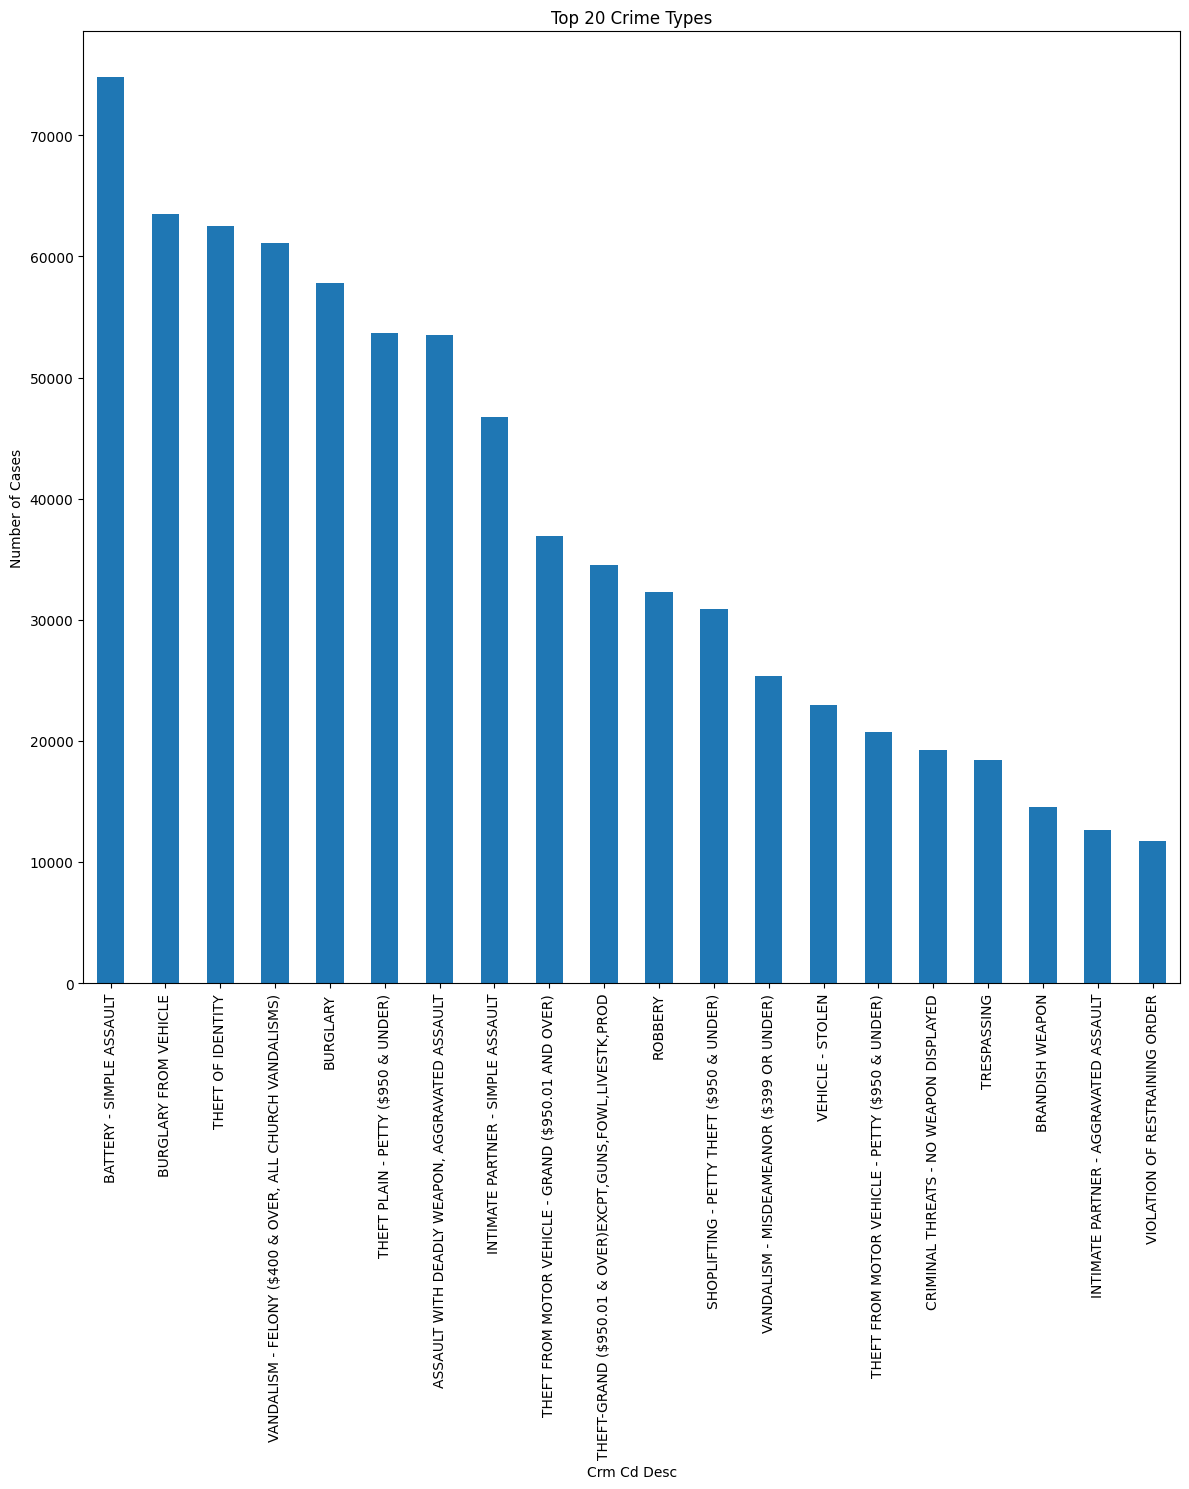

Crm Cd Desc
BATTERY - SIMPLE ASSAULT                                    0.084375
BURGLARY FROM VEHICLE                                       0.071611
THEFT OF IDENTITY                                           0.070503
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     0.068877
BURGLARY                                                    0.065212
THEFT PLAIN - PETTY ($950 & UNDER)                          0.060556
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              0.060346
INTIMATE PARTNER - SIMPLE ASSAULT                           0.052663
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         0.041648
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    0.038881
Name: proportion, dtype: float64

In [26]:
# Frequency of top 20 crime descriptions
plt.figure(figsize=(12, 15))
df['Crm Cd Desc'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Crime Types")
plt.ylabel("Number of Cases")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Normalize counts
df['Crm Cd Desc'].value_counts(normalize=True).head(10)

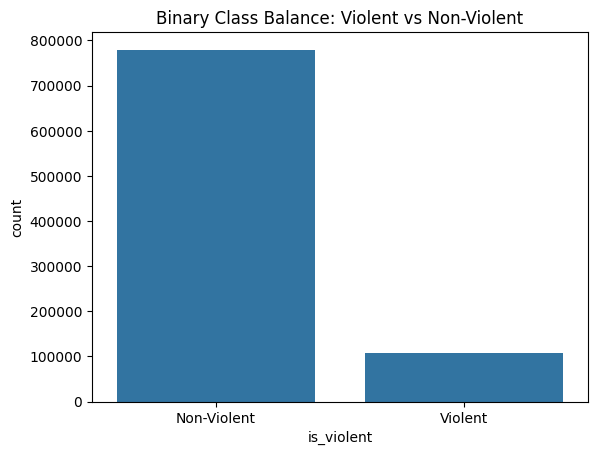

In [27]:
# Define a binary target (example: Violent vs Non-Violent)
violent_crimes = ['BATTERY - SIMPLE ASSAULT', 'RAPE', 'ROBBERY']
df['is_violent'] = df['Crm Cd Desc'].isin(violent_crimes).astype(int)

# Plot class balance
sns.countplot(x='is_violent', data=df)
plt.title("Binary Class Balance: Violent vs Non-Violent")
plt.xticks([0, 1], ['Non-Violent', 'Violent'])
plt.show()

The dataset is heavily imbalanced toward non-violent crimes. This may bias any predictive models trained on it. To address this, data resampling or model techniques that account for class imbalance should be considered. For example, applying SMOTE to oversample violent cases or using algorithms with class weighting can help ensure more balanced performance across both classes.

In [28]:
df['Vict Descent'].value_counts(normalize=True)

Vict Descent
H      0.334177
W      0.227110
B      0.153124
X      0.120284
O      0.087949
nan    0.030022
A      0.024059
K      0.006753
F      0.005454
C      0.005221
J      0.001788
V      0.001347
I      0.001144
Z      0.000651
P      0.000325
U      0.000249
D      0.000103
L      0.000087
G      0.000083
S      0.000065
-      0.000002
Name: proportion, dtype: float64

## Predictive Crime Mapping

In [29]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import contextily as ctx
# import geopandas as gpd
# from shapely.geometry import Point

# # Load and filter data
# crime_df = df[['LAT', 'LON']].dropna()
# crime_df = crime_df[(crime_df['LAT'].between(33.5, 34.5)) & (crime_df['LON'].between(-119, -117.5))]

# # Convert to GeoDataFrame and reproject
# geometry = [Point(xy) for xy in zip(crime_df['LON'], crime_df['LAT'])]
# gdf = gpd.GeoDataFrame(crime_df, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# # Get x and y for KDE
# x = gdf.geometry.x
# y = gdf.geometry.y

# # Create plot
# fig, ax = plt.subplots(figsize=(12, 10))

# # Draw KDE heatmap with higher contrast
# kde = sns.kdeplot(
#     x=x, y=y,
#     fill=True,
#     cmap="Reds",      # Higher contrast colormap
#     alpha=0.6,
#     bw_adjust=0.3,       # More sensitive to clusters
#     thresh=0.001,        # Capture lower densities
#     levels=100,
#     ax=ax
# )

# # Add map background
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.7)

# # Add colorbar legend
# mappable = kde.collections[0]
# cbar = plt.colorbar(mappable, ax=ax, orientation="vertical", pad=0.01)
# cbar.set_label("Crime Density", fontsize=12)

# # Final cleanup
# ax.set_title("Los Angeles Crime Density Heatmap", fontsize=16)
# ax.set_axis_off()

# # Save figure
# plt.savefig("la_crime_heatmap_with_legend.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("Saved: la_crime_heatmap_with_legend.png")

In [30]:
# from IPython.display import Image, display

# display(Image(filename='la_crime_heatmap_with_legend.png'))

The heatmap shows that most crimes in Los Angeles happen in Downtown LA and nearby areas like South Central and Mid-City. These places are colored dark red, which means they have a high number of crimes. Areas like Inglewood, Glendale, and Long Beach have some crime, but not as much. Places like Santa Monica and Calabasas have very little crime.

This pattern happens for a few reasons. Downtown LA is very busy, with lots of people, businesses, and traffic. That makes it easier for crimes like theft or fights to happen. In some areas with less money or fewer job opportunities, crime can be higher because people may struggle more or there may not be enough police or community help. Richer areas usually have less crime and more safety programs, so the crime numbers are lower.

### Graph 2: Time-Series Crime Trend Line Chart
This line chart plots crime counts over time by area, with a simple moving average to simulate a predictive trend.

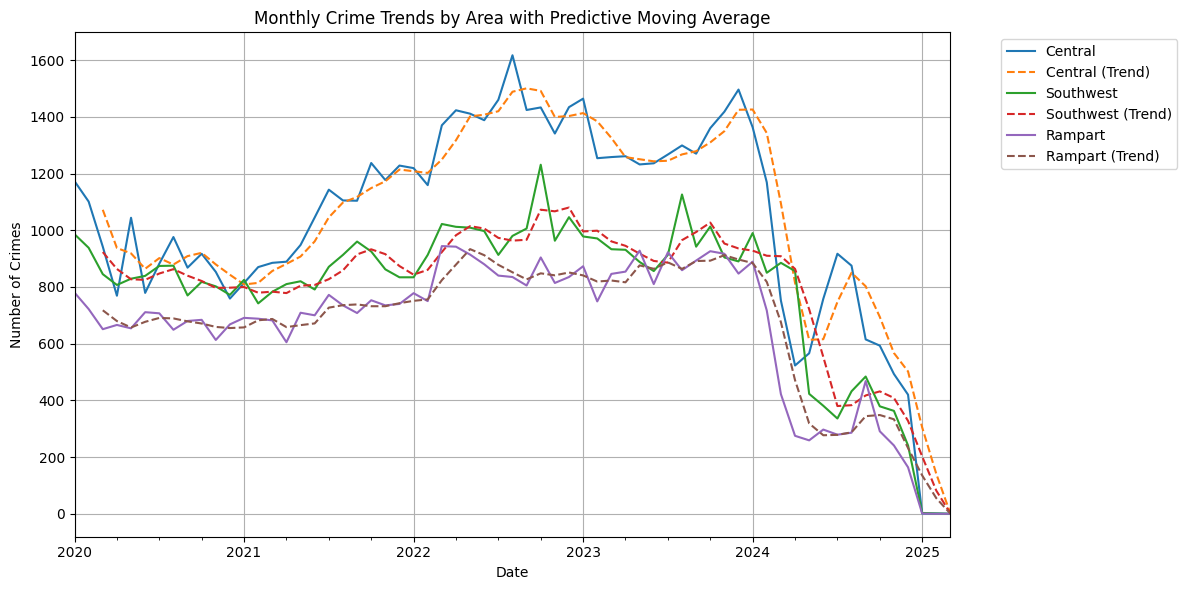

In [31]:
# Group by date and area to count crimes
trend_df = df.groupby([df['DATE OCC'].dt.to_period('M'), 'AREA NAME']).size().unstack(fill_value=0)

# Plot line chart for selected areas
plt.figure(figsize=(12, 6))
for area in ['Central', 'Southwest', 'Rampart']:  # Example areas
    trend_df[area].plot(label=area)
    # Add a simple moving average as a "predictive" trend
    trend_df[area].rolling(window=3).mean().plot(label=f'{area} (Trend)', linestyle='--')

plt.title('Monthly Crime Trends by Area with Predictive Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Victim Risk Profiling

### Graph 1: Stacked Bar Chart of Victim Demographics by Crime Type
This stacked bar chart shows victim demographics (sex and descent) for different crime types.

C:\Users\patti\AppData\Local\Temp\ipykernel_24384\3979004469.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=victim_counts.index, y=victim_counts.values, palette='viridis')


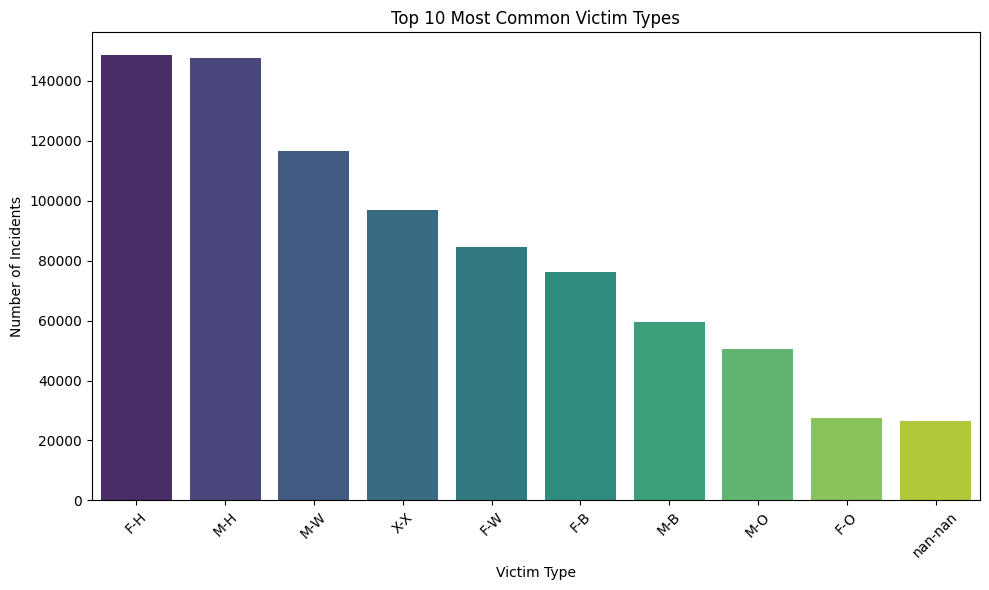

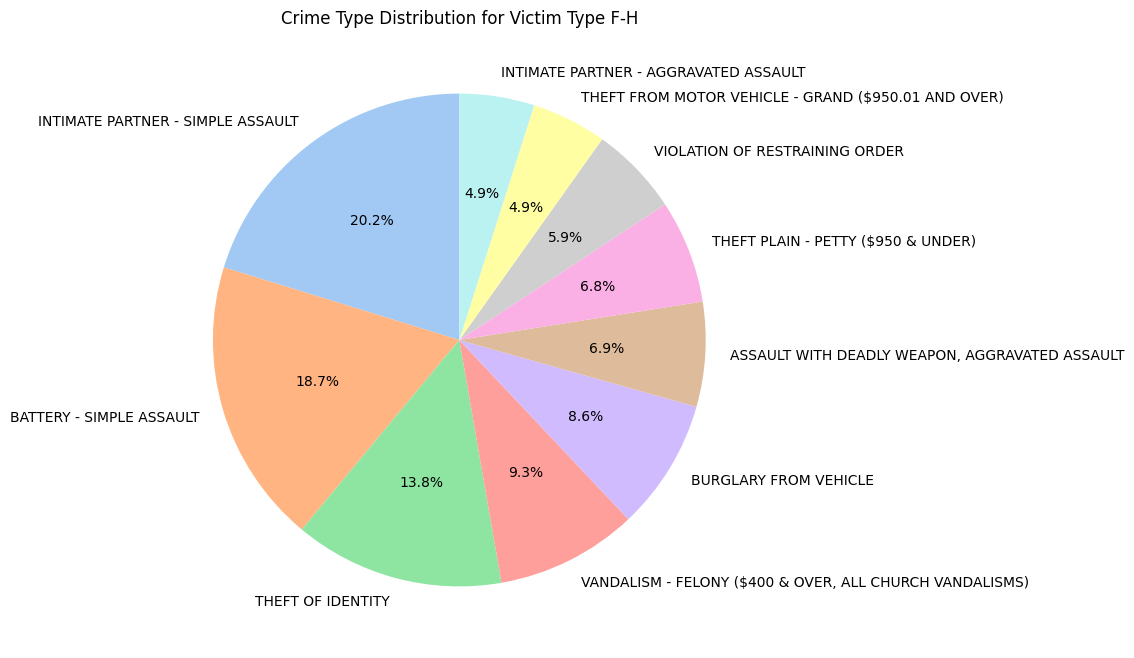

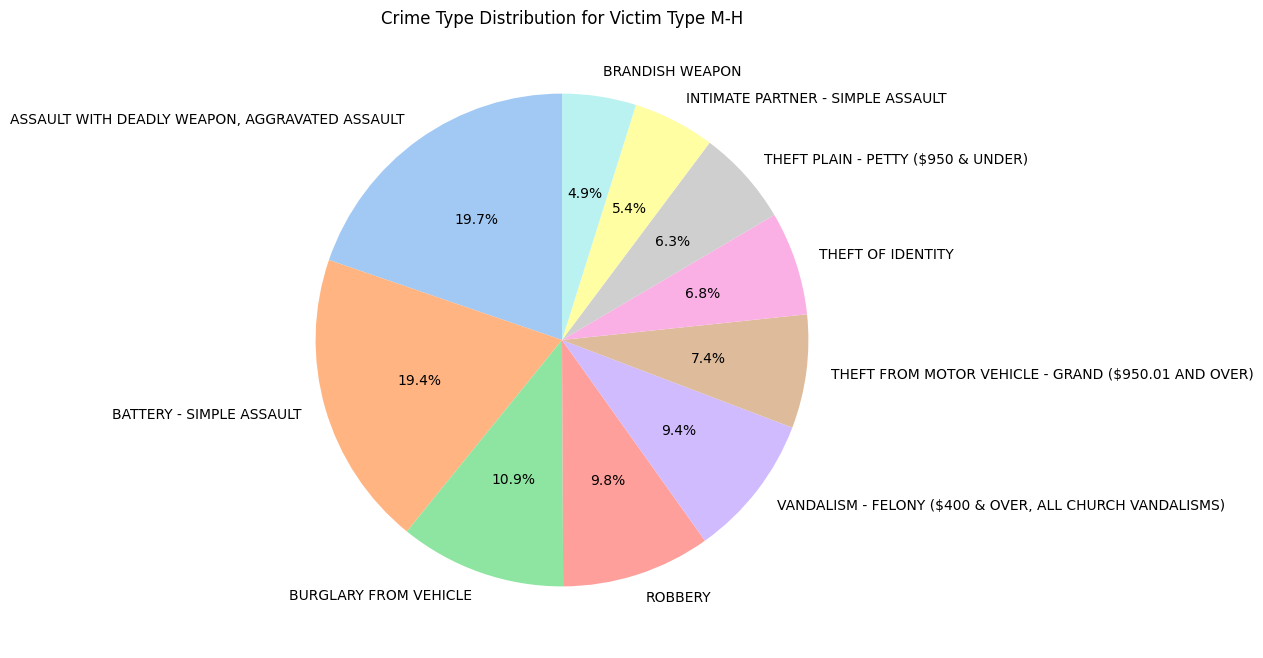

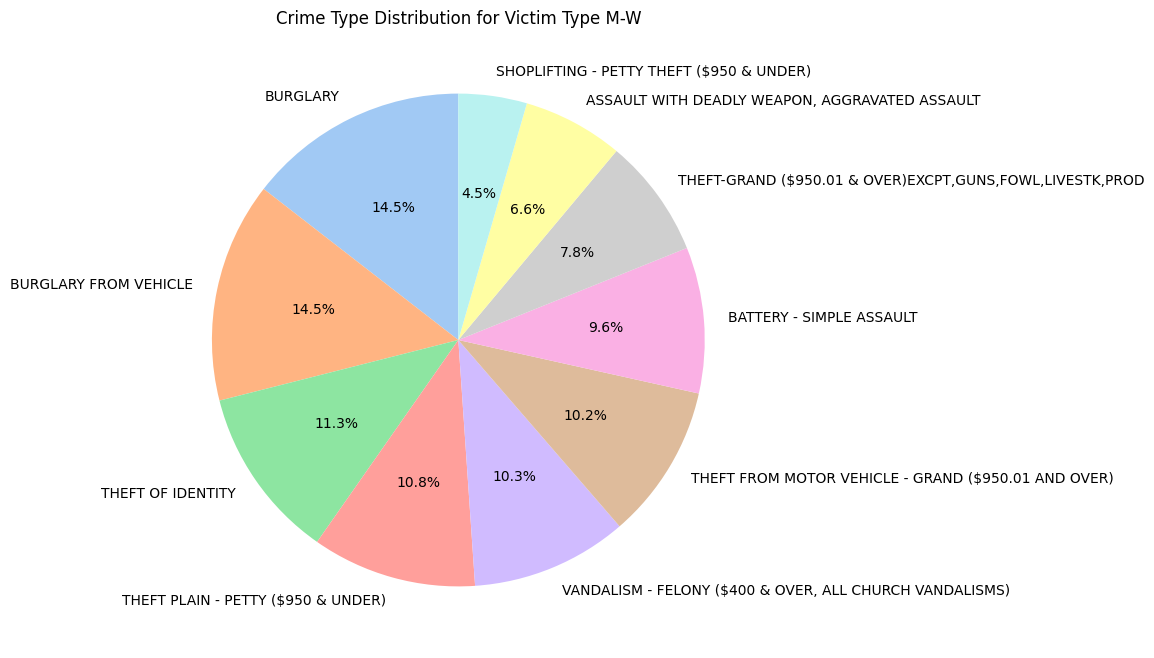

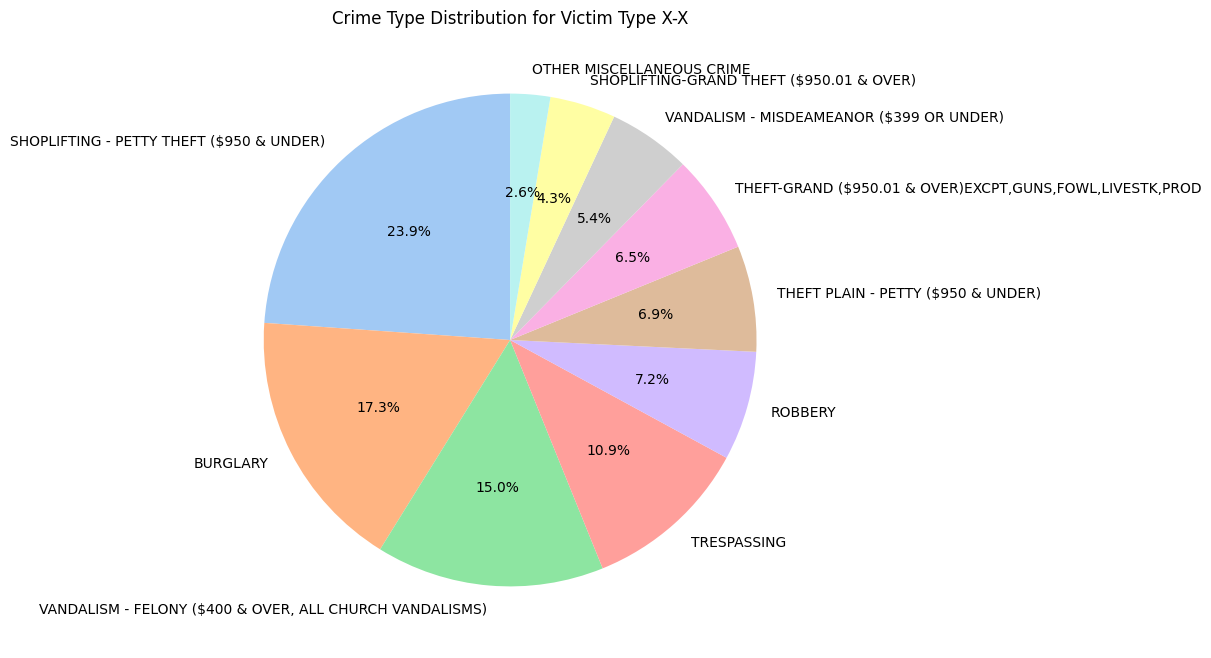

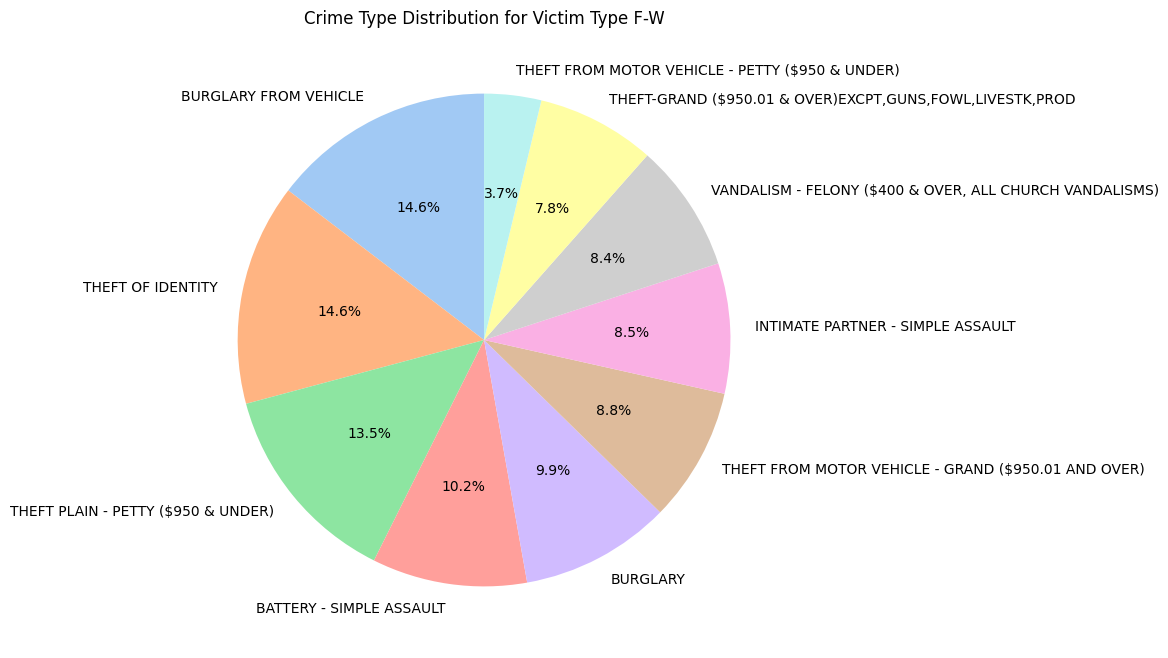

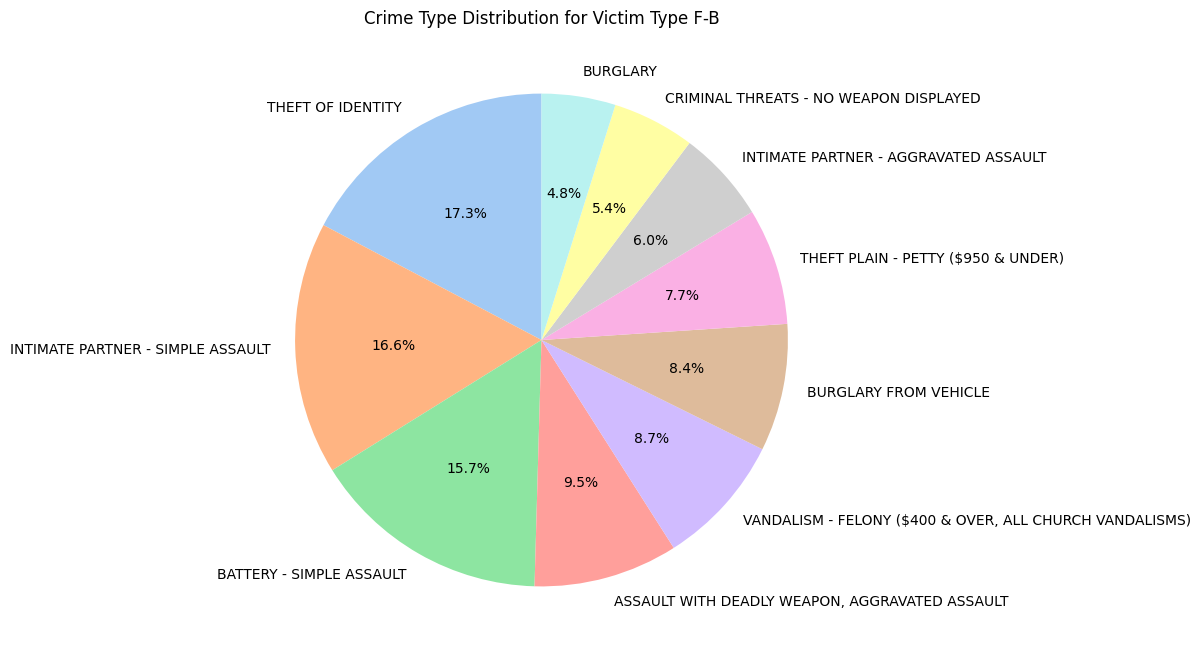

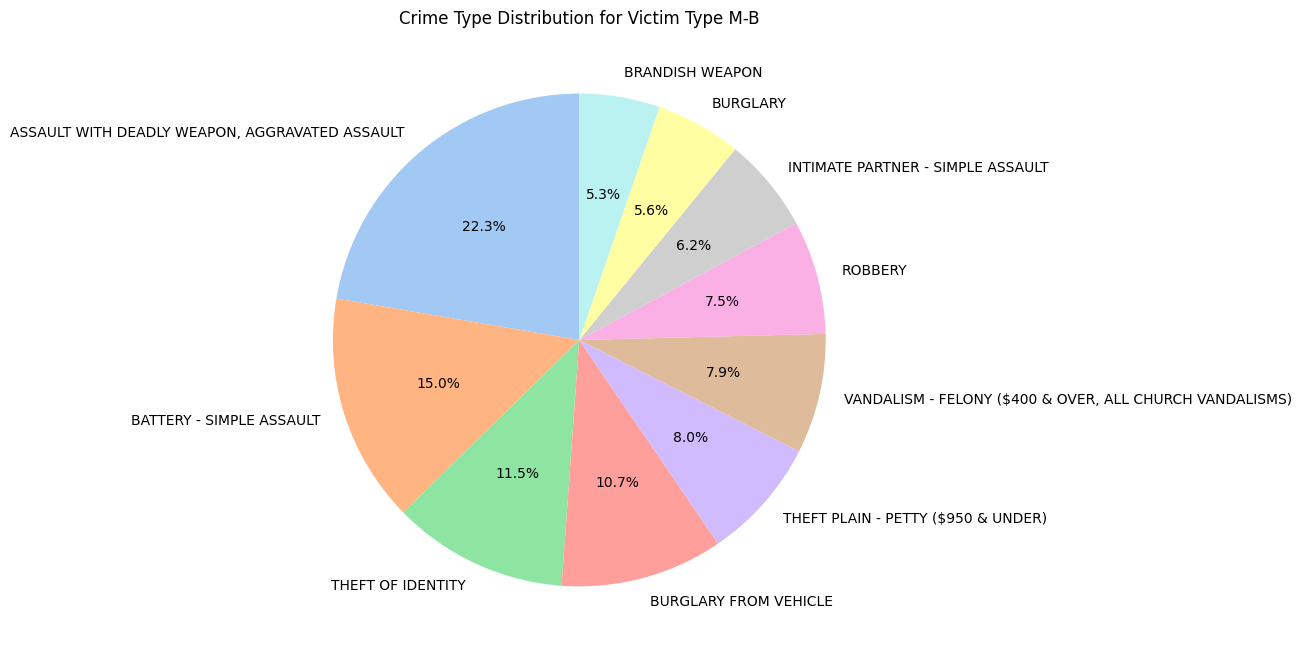

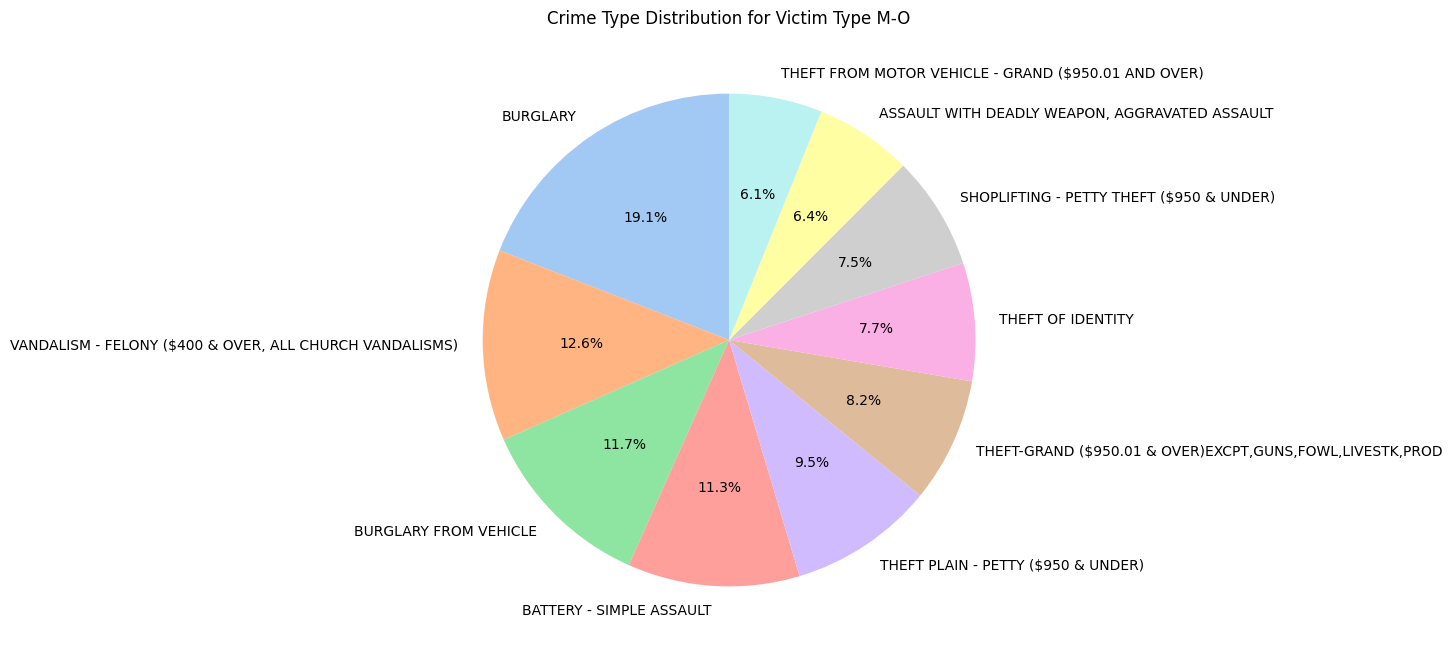

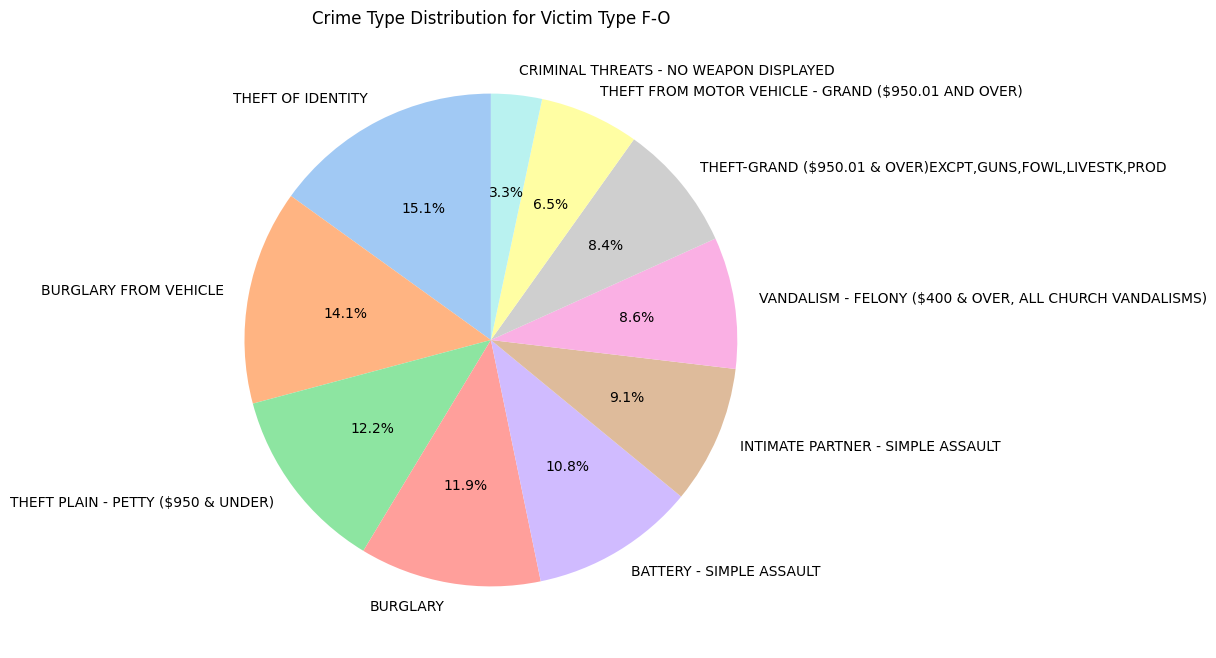

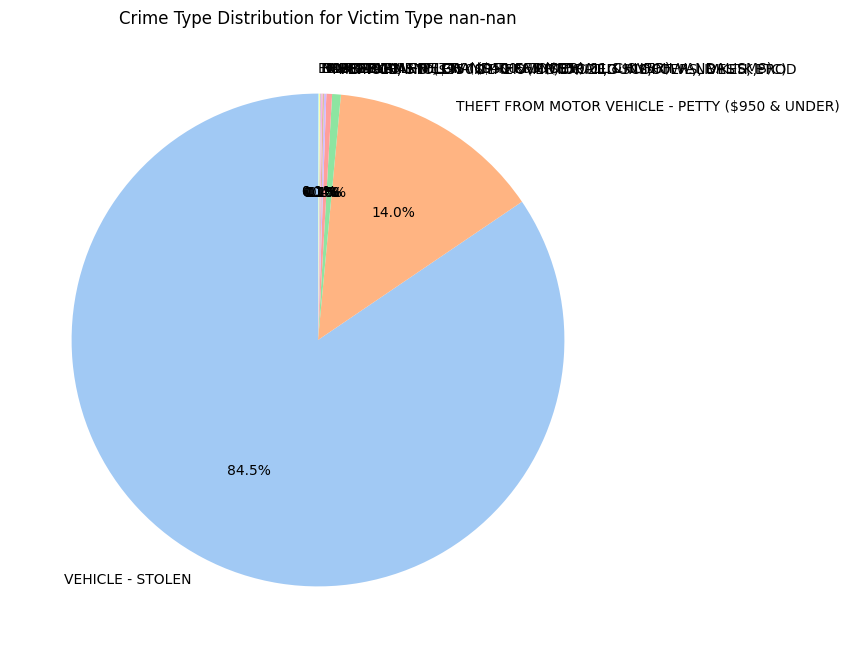

In [32]:
# Create Victim Type column (combining Vict Sex and Vict Descent)
df['Victim Type'] = df['Vict Sex'] + '-' + df['Vict Descent']

# Handle missing values
victim_counts = df.dropna(subset=['Victim Type', 'Crm Cd Desc'])

# --- Chart 1: Bar Plot - Top 10 Most Common Victim Types ---
# Count occurrences of each Victim Type and select top 10
victim_counts = df['Victim Type'].value_counts().head(10)

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=victim_counts.index, y=victim_counts.values, palette='viridis')
plt.title('Top 10 Most Common Victim Types')
plt.xlabel('Victim Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Chart 2: Pie Chart - Crime Type Proportion for Each Victim Type ---
# Get top 10 Victim Types
top_10_victims = victim_counts.index

# Plot a pie chart for each Victim Type
for victim in top_10_victims:
    # Filter data for this Victim Type
    victim_data = df[df['Victim Type'] == victim]
    
    # Calculate crime type proportions (top 5 for clarity)
    crime_counts = victim_data['Crm Cd Desc'].value_counts(normalize=True).head(10)
    
    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(crime_counts, labels=crime_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title(f'Crime Type Distribution for Victim Type {victim}')
    plt.show()

### Graph 2: Pie Chart of Victim Risk by Premise Type
This pie chart displays the proportion of victims by premise type, segmented by age groups.

C:\Users\patti\AppData\Local\Temp\ipykernel_24384\4173095463.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_premises.index, y=top_10_premises.values, palette='viridis')


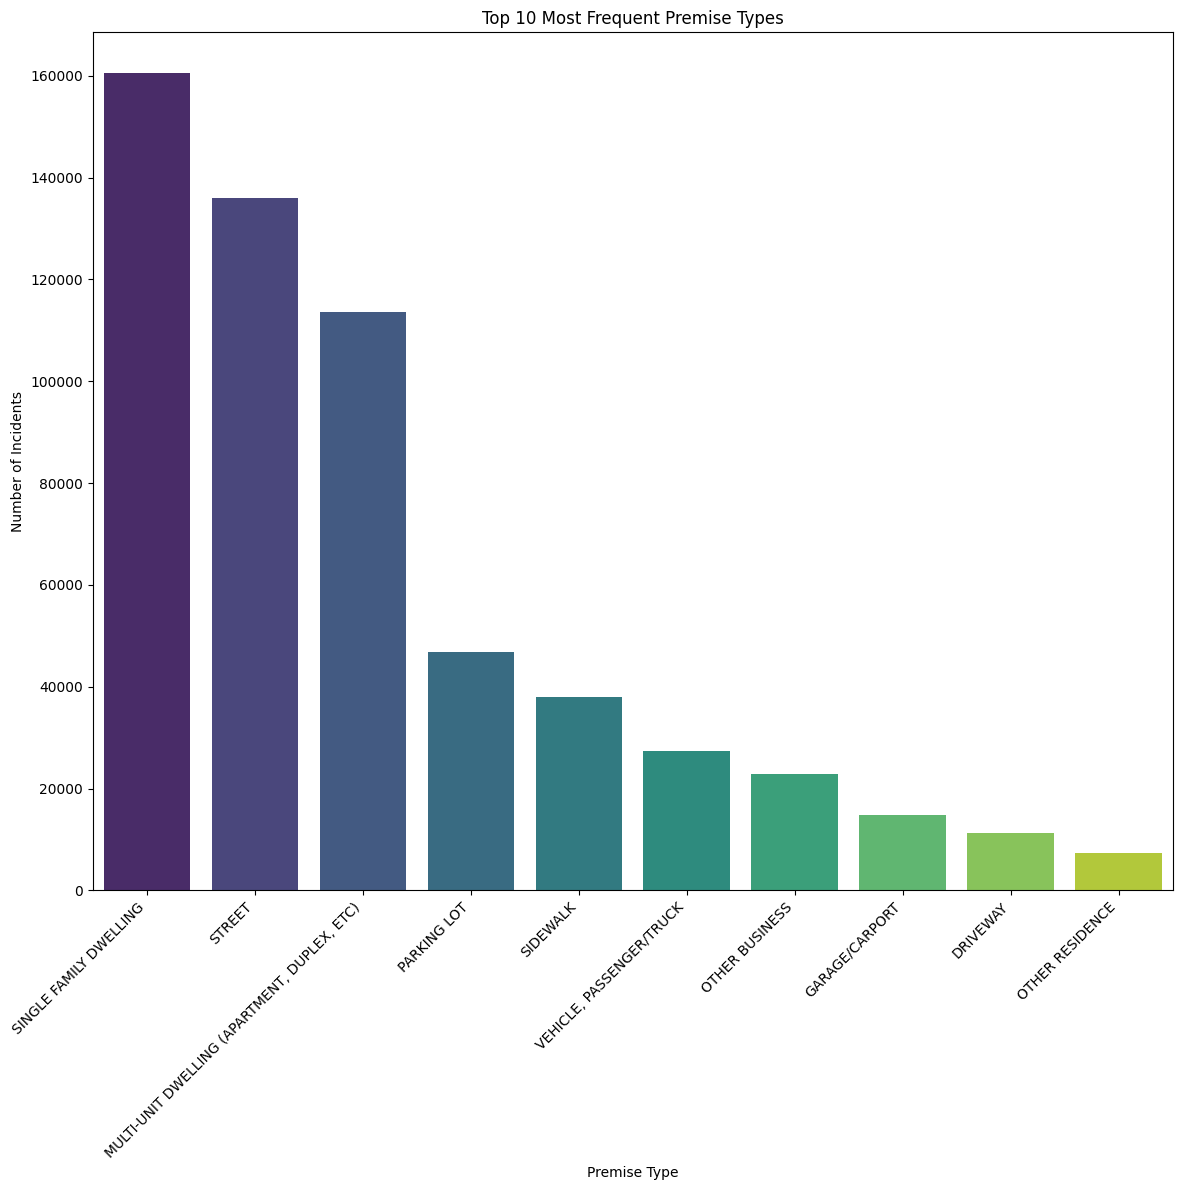

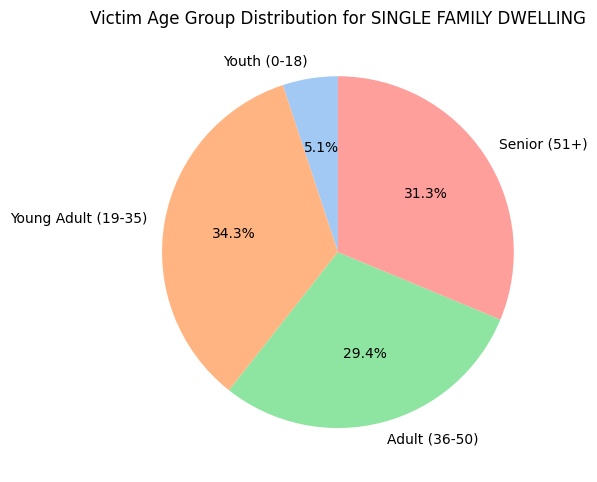

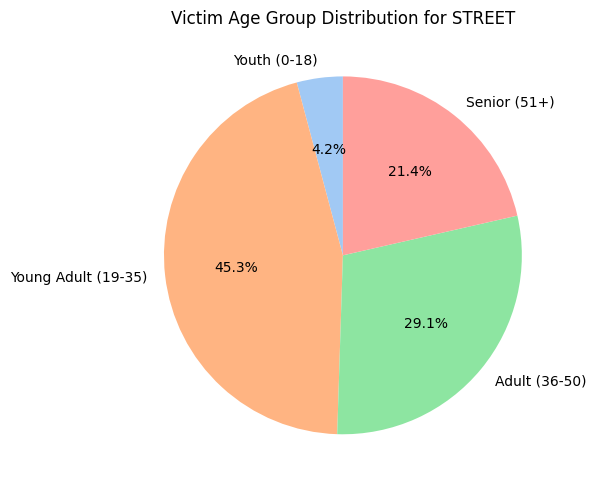

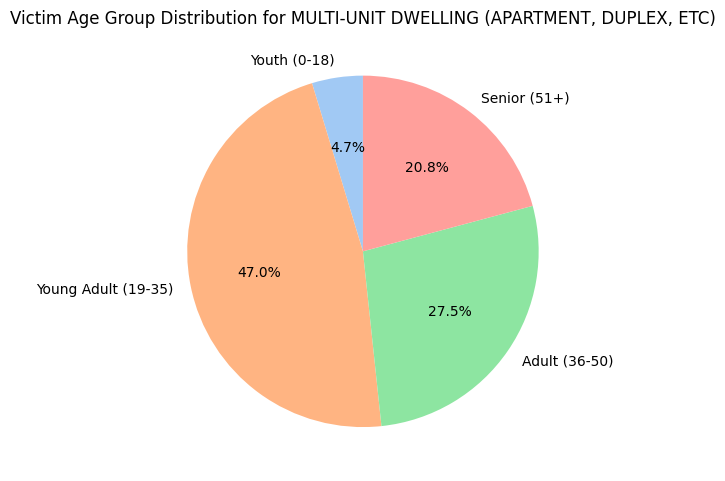

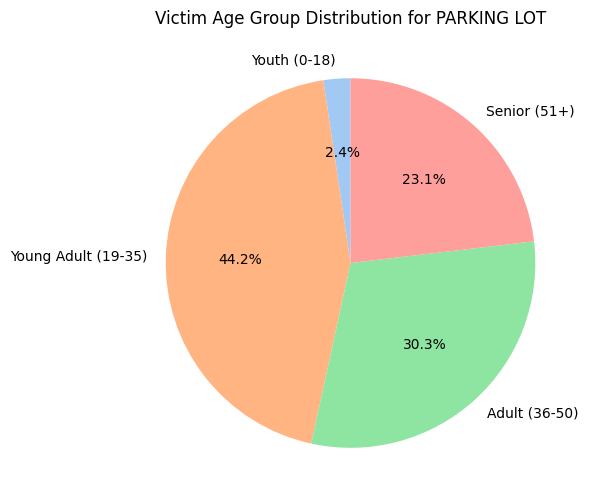

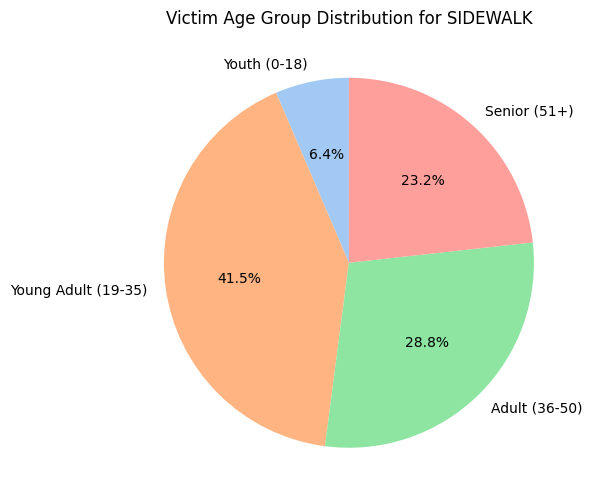

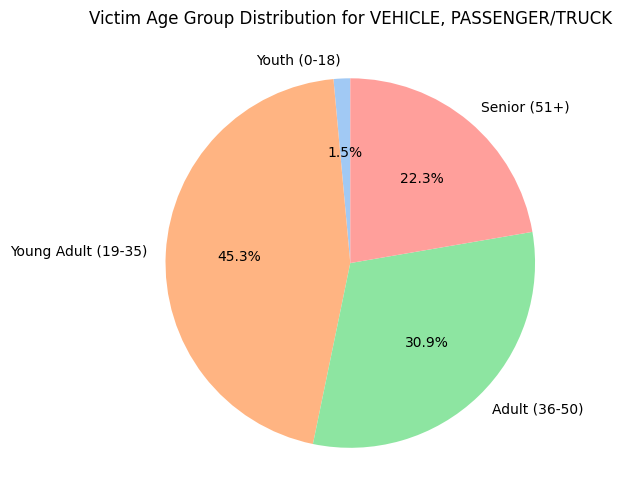

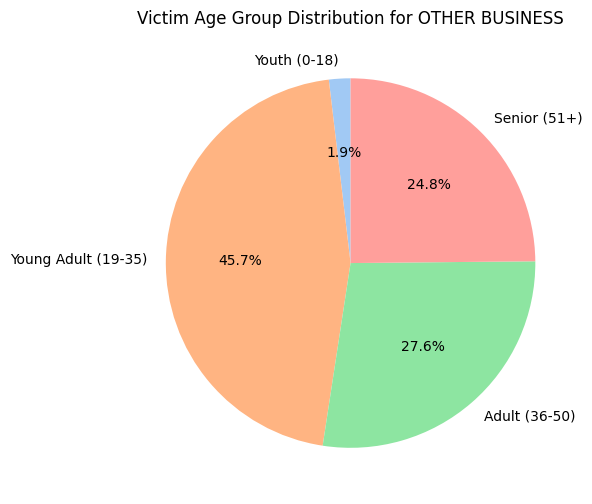

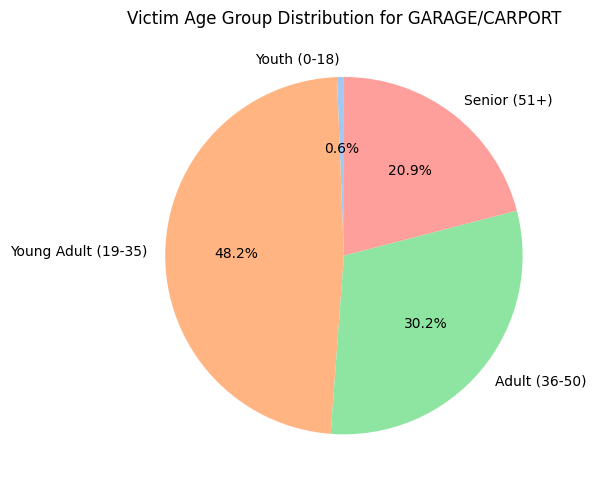

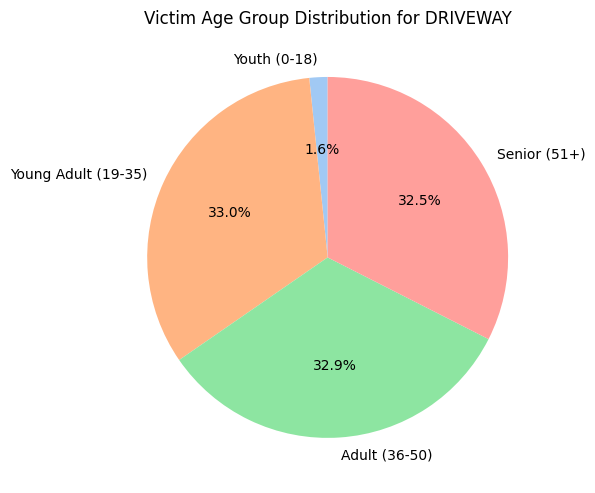

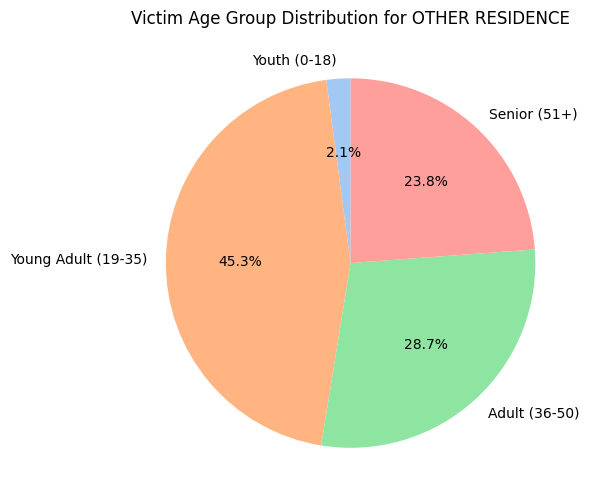

In [33]:
# Filter relevant columns and handle missing values
premise_df = df[['Premis Desc', 'Vict Age']].dropna()

# Filter out invalid ages (e.g., <= 0)
premise_df = premise_df[premise_df['Vict Age'] > 0]

# Bin victim ages into age groups
bins = [0, 18, 35, 50, 100]
labels = ['Youth (0-18)', 'Young Adult (19-35)', 'Adult (36-50)', 'Senior (51+)']
premise_df['Age Group'] = pd.cut(premise_df['Vict Age'], bins=bins, labels=labels, include_lowest=True)

# Calculate the top 10 most common premise types
top_10_premises = premise_df['Premis Desc'].value_counts().head(10)

# Plot bar chart
plt.figure(figsize=(12, 12))
sns.barplot(x=top_10_premises.index, y=top_10_premises.values, palette='viridis')
plt.title('Top 10 Most Frequent Premise Types')
plt.xlabel('Premise Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# For each of the top 10 premises, plot a pie chart showing the proportion of each age group
for premise in top_10_premises.index:
    premise_data = premise_df[premise_df['Premis Desc'] == premise]['Age Group'].value_counts().sort_index()
    plt.figure(figsize=(6, 6))
    plt.pie(premise_data, labels=premise_data.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title(f'Victim Age Group Distribution for {premise}')
    plt.tight_layout()
    plt.show()


## Smart Patrol Route Planning

### Graph 1: Geospatial Route Optimization Map
This interactive scatter map uses Plotly to plot crime locations with a simulated route based on time order.

In [34]:
# Filter relevant columns and remove rows with missing LAT/LON
route_df = df[['LAT', 'LON', 'AREA NAME', 'TIME OCC', 'Crm Cd Desc']].dropna()

# Sort by time to simulate a patrol route
route_df = route_df.sort_values('TIME OCC')

# Create an interactive scatter map
fig = px.scatter_mapbox(route_df, lat="LAT", lon="LON", color="AREA NAME", size_max=15, zoom=10,
                        mapbox_style="open-street-map", title="Smart Patrol Route Planning",
                        hover_df=["Crm Cd Desc", "TIME OCC"])

# Add a line to simulate the route
fig.add_trace(px.line_mapbox(route_df, lat="LAT", lon="LON").df[0])
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.write_html('patrol_route_map.html')

TypeError: scatter_mapbox() got an unexpected keyword argument 'hover_df'

### Graph 2: Patrol Coverage vs. Crime Heatmap Overlay
This dual-layer heatmap compares crime density against a simulated patrol coverage.

In [ ]:
# Filter relevant columns and remove rows with missing LAT/LON
crime_df = df[['LAT', 'LON']].dropna()

# Simulate patrol coverage with a subset of locations (e.g., half the df)
patrol_df = crime_df.sample(frac=0.5, random_state=42)

# Create 2D histograms for crime and patrol df
crime_heatmap, xedges, yedges = np.histogram2d(crime_df['LON'], crime_df['LAT'], bins=100)
patrol_heatmap, _, _ = np.histogram2d(patrol_df['LON'], patrol_df['LAT'], bins=100)

# Smooth both heatmaps
crime_heatmap = gaussian_filter(crime_heatmap, sigma=1)
patrol_heatmap = gaussian_filter(patrol_heatmap, sigma=1)

# Plot crime heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(crime_heatmap.T, origin='lower', cmap='Reds', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Crime Density')
plt.title('Crime Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot patrol coverage heatmap
plt.subplot(1, 2, 2)
plt.imshow(patrol_heatmap.T, origin='lower', cmap='Blues', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Patrol Coverage')
plt.title('Patrol Coverage Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.savefig('patrol_coverage_heatmap.png')